# Training

In [1]:
import re

#library to read and import file from drive
import os

import cv2 as cv

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

#### Functions

In [2]:
# Load train images (all without defects)
def train_loader(dir='./', scale=False):
    imgs = []
    for img in os.listdir(dir):
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        imgs.append(image)
    return imgs

In [3]:
# Load the validation set (all with defects)
def test_loader(dir='./', scale=False):
    imgs = {}
    for img in os.listdir(dir):
        img_num = int(re.findall(r'NOK_(\d+)-', img)[0])
        img_order = int(re.findall(r'NOK_\d+-(\d+)', img)[0])
        image = cv.imread((dir + '/' + img), cv.IMREAD_GRAYSCALE)
        if scale:
            image = image.astype('float32') / 255.
        if img_num in imgs.keys():
            imgs[img_num].append([img_order, image])
        else:
            imgs[img_num] = [[img_order, image]]
    return imgs

In [4]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

## Data loader

In [5]:
X_train = train_loader('../Data/Prepared/Train/OK', scale=True)
X_noisy = train_loader('../Data/Prepared/Train/noisyOK', scale=True)
X_anomaly = test_loader('../Data/Prepared/Train/NOK', scale=True)

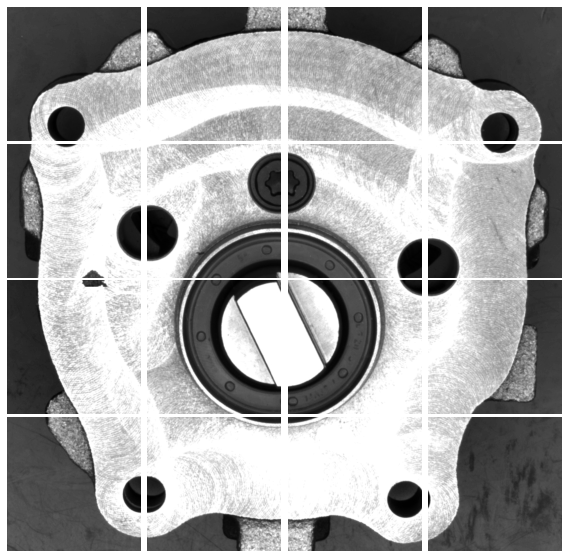

In [6]:
plt.figure(figsize=(10, 10))
for part in X_anomaly[1]:
    plt.subplot(4, 4, (part[0]+1))
    plt.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.imshow(part[1], cmap='gray')

## Train e validation set

In [7]:
X_train, X__train_val = train_test_split(np.expand_dims(np.array(X_train), -1), test_size=0.2, random_state=17)
X_noisy, X__noisy_val = train_test_split(np.expand_dims(np.array(X_noisy), -1), test_size=0.2, random_state=17)

# Autoencoder

### Diverse architeture di autoencoder

Autoencoder con convolutional

In [8]:
# Create the Encoder and Decoder

#pass the gray scale input image of size(256,256,1)
inputs = tf.keras.Input(shape=(256, 256, 1), name='input_layer')

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(encoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

Autoencoder con fully connected

In [8]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

### Autoencoder compile e fit

In [13]:
IMG_SHAPE = X_train.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 128)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

In [14]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 128)               8388736   
_________________________________________________________________
sequential_3 (Sequential)    (None, 256, 256, 1)       8454144   
Total params: 16,842,880
Trainable params: 16,842,880
Non-trainable params: 0
_________________________________________________________________


In [17]:
def plot_hist(hist, title):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [16]:
#add early stopping
custom_early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001, mode='min')

hist=autoencoder.fit(X_noisy, X_train, epochs=300, batch_size=16, shuffle=True,
                     validation_data=(X__noisy_val, X__train_val), callbacks=[custom_early_stopping])

Epoch 1/300
67/67 [==============================] - 8s 125ms/step - loss: 0.8971 - val_loss: 0.0782
Epoch 2/300
67/67 [==============================] - 9s 127ms/step - loss: 0.0750 - val_loss: 0.0742
Epoch 3/300
67/67 [==============================] - 9s 130ms/step - loss: 0.0722 - val_loss: 0.0710
Epoch 4/300
67/67 [==============================] - 8s 124ms/step - loss: 0.0682 - val_loss: 0.0659
Epoch 5/300
67/67 [==============================] - 8s 125ms/step - loss: 0.0626 - val_loss: 0.0596
Epoch 6/300
67/67 [==============================] - 8s 123ms/step - loss: 0.0563 - val_loss: 0.0528
Epoch 7/300
67/67 [==============================] - 8s 121ms/step - loss: 0.0504 - val_loss: 0.0473
Epoch 8/300
67/67 [==============================] - 8s 124ms/step - loss: 0.0457 - val_loss: 0.0430
Epoch 9/300
67/67 [==============================] - 8s 123ms/step - loss: 0.0421 - val_loss: 0.0397
Epoch 10/300
67/67 [==============================] - 10s 143ms/step - loss: 0.0392 - val_l

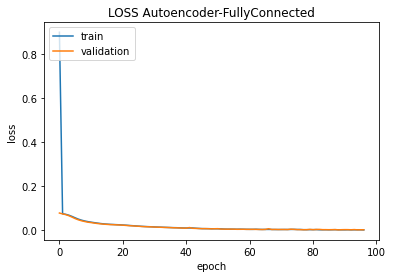

In [19]:
plot_hist(hist, 'Autoencoder-FullyConnected')

### Sample with spot artificially producted

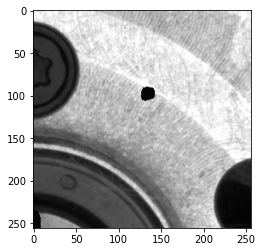

In [20]:
plt.imshow(X_noisy[5], cmap='gray')

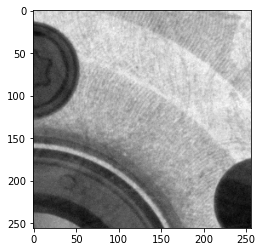

In [21]:
test_artificial = autoencoder.predict(np.expand_dims(X_noisy[5],0))
plt.imshow(np.squeeze(test_artificial[0], -1), cmap='gray')

### Sample with real spot

In [22]:
sample = cv.imread("../Data/Prepared/Test/NOK/NOK_0-14.jpg", cv.IMREAD_GRAYSCALE)

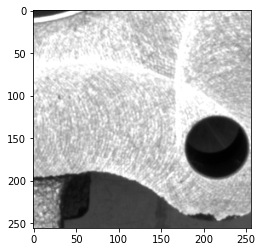

In [23]:
plt.imshow(sample, cmap='gray')

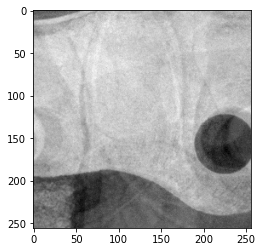

In [24]:
test_real = autoencoder.predict(np.expand_dims(sample,0))
plt.imshow(np.squeeze(test_real[0], -1), cmap='gray')

### Saving model 

In [25]:
autoencoder.save("../Models/autoencoderFC")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/autoencoderFC\assets
